In [1]:
import numpy as np
import pandas as pd
import os, cv2
import aniposelib
import scipy.io

In [41]:
data_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole_stage57_2022-11-04/DLTdv8_data_V1xypts.csv'
calib_path = '/mnt/soma_cifs/Iyer/Filming/02112022a/calibrationwater_1515/calibration.toml'
label3d_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/label3d_data.mat';
label3d_path1 = '/mnt/soma_cifs/Iyer/DANNCE_Files/backup/tadpole-stage57_Nov2022b/label3d_data.mat';
path_ = '/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/';
calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
n_frames = 46
n_pts = 23
tail_framenames = np.sort(os.listdir(path_))[:5]
tail_framenames

array(['1_0-1477', '1_2200-3340', '20_6011-7919', '20_9661-11999',
       '21_0-2061'], dtype='<U14')

In [42]:
def get_3dpts(df, j):
    return calibration_.triangulate_ransac(np.array([df[df.columns[2*i : 2*i + 2]].to_numpy() for i in range(3*j,3*j + 3)]))[0]

In [43]:
def get_tailpt(t, i):
    try:
        pts3d = np.load(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{t}_{i[3:7]}.npy')
    except:
        pts3d = np.zeros((10,3))*np.nan
    return pts3d

In [44]:
def get_tail3d():
    tail3d = []
    for t in tail_framenames:
        I = sorted([j for j in os.listdir(f'{path_}{t}') if 'png' in j])
        tail_pts3d = np.array([get_tailpt(t, i) for i in I]); # (n_frame x 10 x 3)
        for tail in tail_pts3d:
            tail3d.append(tail)
    tail3d = np.array(tail3d)
    return tail3d

In [45]:
from typing import List, Dict, Text, Union
def load_label3d_data(path: Text, key: Text):
    """Load Label3D data
    Args:
        path (Text): Path to Label3D file
        key (Text): Field to access
    Returns:
        TYPE: Data from field
    """
    d = scipy.io.loadmat(path)[key]
    dataset = [f[0] for f in d]

    # Data are loaded in this annoying structure where the array
    # we want is at dataset[i][key][0,0], as a nested array of arrays.
    # Simplify this structure (a numpy record array) here.
    # Additionally, cannot use views here because of shape mismatches. Define
    # new dict and return.
    data = []
    for d in dataset:
        d_ = {}
        for key in d.dtype.names:
            d_[key] = d[key][0, 0]
        data.append(d_)
    return data

def get_frame(idx: int, grayscale: bool = None) -> np.ndarray:
    """See :class:`Video`."""

    v.set(cv2.CAP_PROP_POS_FRAMES, idx)
    success, frame = v.read()

    if not success or frame is None:
        raise KeyError(f"Unable to load frame {idx}")


    return frame

In [46]:
df = pd.read_csv(data_path)
torso3d = np.array([get_3dpts(df, i) for i in range(13)]) # (13, 88, 3)
tail3d = get_tail3d()
pts3d = np.concatenate((np.transpose(torso3d, [1,0,2]), tail3d), axis = 1)
p2d = calibration_.project(pts3d).reshape(3, -1, 23, 2)


matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];

for cam_num in [0,1,2]:
    matfile_['labelData'][0][0][cam_num][0]['data_2d'][0][0] = p2d[cam_num].reshape(-1, n_pts*2)
    matfile_['labelData'][0][0][cam_num][0]['data_3d'][0][0] = pts3d.reshape(-1, n_pts*3)
    matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0]) - 1
    matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0]) - 1

scipy.io.savemat(label3d_path, {'camnames':matfile_['camnames'][0][0], 'params':matfile_['params'][0][0], 'sync':matfile_['sync'][0][0], 'labelData':matfile_['labelData'][0][0]})

In [47]:
for cam_num in [1,2,3]:
    v = cv2.VideoCapture(f'/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/videos/Camera{cam_num}/0.avi')
    df = load_label3d_data(label3d_path, 'labelData')[cam_num - 1]['data_2d']
    for idx in range(n_frames):
        x = df[idx][::2].astype(np.int32)
        y = df[idx][1::2].astype(np.int32)
        im_ = get_frame(idx)
        for i in range(len(x)):
            im_ = cv2.circle(im_, [x[i], y[i]], radius=4, color=(0, 255, 255), thickness=-1)
        cv2.imwrite(f'/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/test/c{cam_num}_{idx}.png', im_)

In [20]:
pd.isna(get_tail3d()[0][0][0])

True

In [208]:
v = cv2.VideoCapture('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/videos/Camera1/0.avi')
def get_frame(v, idx):
    v.set(cv2.CAP_PROP_POS_FRAMES, idx)
    _, r = v.read()
    return r

In [133]:
load_camnames(label3d_path)

['Camera1', 'Camera2', 'Camera3']

In [122]:
def load_camnames(path: Text) -> Union[List, None]:
    """Load camera names from .mat file.
    Args:
        path (Text): Path to .mat file with "camnames" field
    Returns:
        Union[List, None]: List of cameranames
    """
    label_3d_file = scipy.io.loadmat(path)
    if "camnames" in label_3d_file:
        names = label_3d_file["camnames"][:]
        if len(names) != len(label_3d_file["labelData"]):
            camnames = [name[0] for name in names[0]]
        else:
            camnames = [name[0][0] for name in names]
    else:
        camnames = None
    return camnames

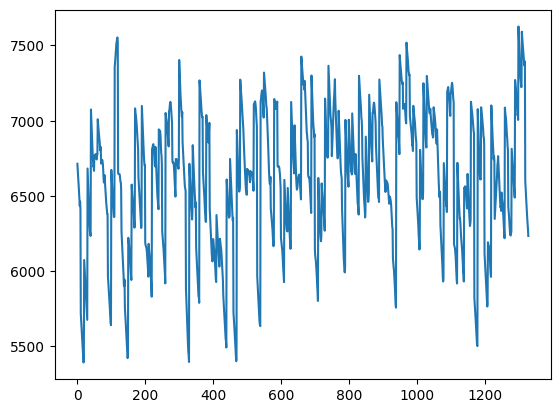

In [15]:
path_ = '/home/iyer_la/Documents/TailAnnotated/DANNCE/'
files_ = [path_ + i for i in os.listdir(path_) if 'points' in i]
z = []
for fi in files_:
    n = np.load(fi)
    z.append(np.linalg.norm(np.diff(n), axis = 1))
z = np.array(z).reshape(-1)
plt.plot(z)
plt.hist(z)

In [261]:
matfile_ = scipy.io.loadmat('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/label3d_dannce.mat')

In [473]:
v = cv2.VideoCapture('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/videos/Camera2/0.avi')
df = load_label3d_data('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/label3d_data.mat', 'labelData')[1]['data_2d']

In [364]:
df = pd.read_csv(data_path);
calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];

df_np = df.to_numpy()

In [454]:
data_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole_stage57_2022-11-04/DLTdv8_data_V1xypts.csv'
df = pd.read_csv(data_path)

In [399]:
pts_ = np.array([df[df.columns[0:2]].to_numpy(), df[df.columns[2:4]].to_numpy(), df[df.columns[4:6]].to_numpy()]
calibration_.triangulate_ransac(pts_)[0]

array([[-2.51045265e+02, -3.85289625e+02,  6.79406928e+03],
       [-4.11888026e+01, -3.62684899e+02,  6.92920305e+03],
       [ 3.76278812e+01, -3.66814839e+02,  6.99772319e+03],
       [ 1.38905069e+02, -3.47692864e+02,  7.07497354e+03],
       [ 4.08194618e+02, -2.71166498e+02,  7.12179752e+03],
       [ 5.13087296e+02, -2.56043667e+02,  7.14787726e+03],
       [ 5.75930347e+02, -2.52940100e+02,  7.16088116e+03],
       [ 5.90437522e+02, -2.99430500e+02,  6.98204664e+03],
       [ 1.00894520e+03, -3.94824679e+02,  6.90728592e+03],
       [ 3.14646416e+02, -3.48060814e+02,  7.14825217e+03],
       [ 2.82546067e+02, -1.38662363e+02,  7.21676627e+03],
       [ 2.69282996e+02, -9.66537873e+01,  7.23330703e+03],
       [ 2.36517147e+02,  4.72647847e+00,  7.26273697e+03],
       [ 2.33011447e+02,  1.79189375e+01,  7.27358752e+03],
       [ 6.41936633e+02,  8.07173833e+01,  7.12249677e+03],
       [ 6.76561244e+02,  9.84297940e+01,  7.13429277e+03],
       [ 8.35413806e+02,  1.88446409e+02

In [5]:
def get_columns(df, txt):
    c1_c = [i for i in df.columns if txt in i]
    c1_cx = [i for i in c1_c if '_X' in i]
    c1_cy = [i for i in c1_c if '_Y' in i]
    x = df[c1_cx].to_numpy().T.reshape(-1)
    y = df[c1_cy].to_numpy().T.reshape(-1)
    return np.array([x,y]).T

In [6]:
def get_tailpts(tail_framenames):
    J = []
    for i in tail_framenames:
        I = sorted([j for j in os.listdir(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{i}') if 'png' in j])
        for j in I:
            J.append(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{i}_{j[3:7]}.npy')
    z = np.zeros((len(J), 10, 3)) * np.nan
    for i, j in enumerate(J):
        try:
            z[i] = np.load(j)
        except:
            print(j)
    return z

In [19]:
def add_pts(data_path, calib_path, label3d_path, n_frames, n_pts):
    df = pd.read_csv(data_path);
    pts = np.array([get_columns(df, 'cam1'), get_columns(df, 'cam2'), get_columns(df, 'cam3')]);
    calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
    xyz = calibration_.triangulate_ransac(pts)[0];
    xyz = xyz.reshape(n_frames, 13, 3);
    
    tail_pts = get_tailpts(tail_framenames);
    all_pts = np.concatenate((xyz, tail_pts), axis = 1);
    all_pts = all_pts.reshape(-1,3)
    
    df_cam = calibration_.project(all_pts)
    matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];
    for cam_num in [0,1,2]:
        matfile_['labelData'][0][0][cam_num][0]['data_2d'][0][0] = df_cam[cam_num].reshape(n_frames, n_pts*2)
        matfile_['labelData'][0][0][cam_num][0]['data_3d'][0][0] = all_pts.reshape(n_frames, n_pts*3)
        matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0]) - 1
        matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0]) - 1

    scipy.io.savemat(label3d_path, {'camnames':matfile_['camnames'][0][0], 'params':matfile_['params'][0][0], 'sync':matfile_['sync'][0][0], 'labelData':matfile_['labelData'][0][0]})

In [20]:
add_pts(data_path, calib_path, label3d_path, n_frames, n_pts)
matfile_ = scipy.io.loadmat(label3d_path)

In [483]:
df = pd.read_csv(data_path);
pts = np.array([get_columns(df, 'cam1'), get_columns(df, 'cam2'), get_columns(df, 'cam3')]);
calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
xyz = calibration_.triangulate_ransac(pts)[0];
xyz = xyz.reshape(n_frames, 13, 3);

tail_pts = get_tailpts(tail_framenames);
all_pts = np.concatenate((xyz, tail_pts), axis = 1);
all_pts = all_pts.reshape(-1,3)

In [499]:
df = pd.read_csv(data_path)
torso3d = np.array([get_3dpts(df, i) for i in range(13)]) # (13, 88, 3)
torso2d = calibration_.project(torso3d).reshape(3, 13, -1, 2)
torso2d = np.array([[torso2d[cam_num][:,i,:] for i in range(n_frames)] for cam_num in [0,1,2]])
tail3d = get_tail3d()
tail2d = calibration_.project(tail3d).reshape(3, -1, 10, 2)
pts2d = np.concatenate((torso2d, tail2d), axis = 2)
pts3d = np.concatenate((np.transpose(torso3d, [1,0,2]), tail3d), axis = 1)

array([[[ 7.29463794e+02,  4.93701648e+02],
        [ 9.28351356e+02,  5.15603458e+02],
        [ 1.00032399e+03,  5.13727406e+02],
        [ 1.09224916e+03,  5.32334160e+02],
        [ 1.33648503e+03,  5.90463771e+02],
        [ 1.42942486e+03,  6.00435174e+02],
        [ 1.48461539e+03,  6.00898952e+02],
        [ 1.50809932e+03,  5.44196057e+02],
        [ 1.89225690e+03,  4.28148992e+02],
        [ 1.24758838e+03,  5.29051951e+02],
        [ 1.22800896e+03,  7.20920626e+02],
        [ 1.21799839e+03,  7.59561242e+02],
        [ 1.19364446e+03,  8.51832699e+02],
        [ 7.64189259e+02,  2.31334243e+02],
        [ 7.43135209e+02,  2.45331095e+02],
        [ 7.14025647e+02,  2.66947751e+02],
        [ 6.87964020e+02,  2.85717784e+02],
        [ 6.63481735e+02,  2.96130357e+02],
        [ 6.44558212e+02,  2.99576868e+02],
        [ 6.41248379e+02,  2.95027726e+02],
        [ 6.47025448e+02,  2.92174377e+02],
        [ 6.36656261e+02,  2.57205344e+02],
        [ 6.56648146e+02,  2.578

In [ ]:
path_ = '/mnt/soma_cifs/Iyer/DeepLabCut_Files/TrainingGround/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/'
hdf5path_ = f'{get_path(0)}{tail_framenames[0]}/CollectedData_Aditya.h5'
df0 = pd.read_hdf(hdf5path_)
hdf5path_ = f'{get_path(1)}{tail_framenames[0]}/CollectedData_Aditya.h5'
df1 = pd.read_hdf(hdf5path_)
hdf5path_ = f'{get_path(2)}{tail_framenames[0]}/CollectedData_Aditya.h5'
df2 = pd.read_hdf(hdf5path_)
df = [df0, df1, df2]